In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import random
from skimage.io import imread
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
main_folder = Path('.')

### 1. Reading images and creating labels

In [3]:
def read_image_and_create_label_from_filepath(filepath):
    img = imread(filepath)
    label = filepath.parts[0]
    return img, label

In [4]:
images, labels = zip(*[read_image_and_create_label_from_filepath(filepath) for filepath in main_folder.rglob("*.png")])

In [5]:
images, labels = shuffle(images, labels)
images = np.asarray(images)
labels = np.asarray(labels)
print('Dataset and image sizes: {}'.format(images.shape))

Dataset and image sizes: (2188, 200, 300, 3)


### 2. Changing created labels into numbers 

In [6]:
le = LabelEncoder()
labels = le.fit_transform(labels)

### 3. Data Normalization

In [7]:
print(images[0].max())
print(images[0].min())
images = images / 255
print(images[0].max())
print(images[0].min())

254
0
0.996078431372549
0.0


(array([0, 1, 2], dtype=int64), array([712, 726, 750], dtype=int64))


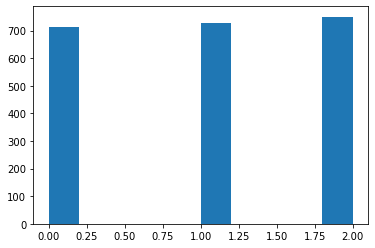

In [8]:
plt.hist(labels)
print(np.unique(labels, return_counts=True))

### 4. Creating training, valid, test sets

In [9]:
training_x, x_test, training_y, y_test = train_test_split(images, labels, test_size = 0.1, random_state = 42) 

In [10]:
print('Number of elements in training_x: {}'.format(len(training_x)))
print('Number of elements in training_y: {}'.format(len(training_y)))
print('Number of elements in x_test: {}'.format(len(x_test)))
print('Number of elements in y_test: {}'.format(len(y_test)))

Number of elements in training_x: 1969
Number of elements in training_y: 1969
Number of elements in x_test: 219
Number of elements in y_test: 219


Split training sets into smaller training and validation sets - test dataset will be used at the very end

In [11]:
x_train, x_valid, y_train, y_valid = train_test_split(training_x, training_y, test_size = 0.2, random_state = 42) 

In [12]:
print('Number of elements in x_train: {}'.format(len(x_train)))
print('Number of elements in y_train: {}'.format(len(y_train)))
print('Number of elements in x_valid: {}'.format(len(x_valid)))
print('Number of elements in y_valid: {}'.format(len(y_valid)))

Number of elements in x_train: 1575
Number of elements in y_train: 1575
Number of elements in x_valid: 394
Number of elements in y_valid: 394


In [13]:
labels_names = list(np.unique(y_valid))
labels_dict = dict(zip(labels_names, ['pap', 'rock', 'sciss']))

In [14]:
def print_imgs(x_set, y_set, names):
    fig, ax = plt.subplots(4, 4, figsize=(9, 9), sharex='col', sharey='row')
    for x in range(4):
        for y in range(4):
            idx = random.randint(0, len(x_set)-1)
            ax[x,y].imshow(x_set[idx], cmap='gray')
            ax[x,y].set_title(names[int(y_set[idx])])

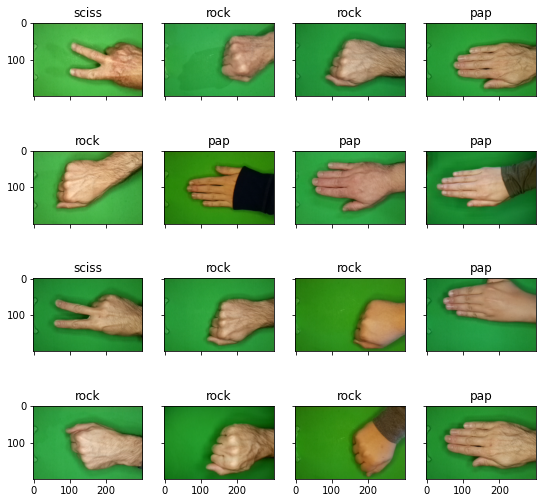

In [15]:
print_imgs(x_train, y_train, labels_dict)

### 5. Create a model

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from sklearn.utils import class_weight

In [17]:
model = tf.keras.Sequential()
model.add(Conv2D(9, (5, 5), activation='relu', input_shape=(200, 300, 3), name='L1'))
model.add(MaxPooling2D((2, 2), name='P1'))
model.add(Conv2D(9, (5, 5), activation='relu', name='L2'))
model.add(MaxPooling2D((2, 2), name='P2'))
model.add(Conv2D(9, (5, 5), activation='relu', name='L3'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_valid, y_valid))

Train on 1575 samples, validate on 394 samples
Epoch 1/10
1575/1575 [==============================] - 27s 17ms/sample - loss: 0.7056 - accuracy: 0.7181 - val_loss: 0.4291 - val_accuracy: 0.8503
Epoch 2/10
1575/1575 [==============================] - 26s 17ms/sample - loss: 0.3110 - accuracy: 0.9010 - val_loss: 0.2088 - val_accuracy: 0.9162
Epoch 3/10
1575/1575 [==============================] - 28s 18ms/sample - loss: 0.1455 - accuracy: 0.9460 - val_loss: 0.1520 - val_accuracy: 0.9391
Epoch 4/10
1575/1575 [==============================] - 28s 18ms/sample - loss: 0.0668 - accuracy: 0.9752 - val_loss: 0.1320 - val_accuracy: 0.9569
Epoch 5/10
1575/1575 [==============================] - 29s 18ms/sample - loss: 0.0256 - accuracy: 0.9937 - val_loss: 0.1383 - val_accuracy: 0.9492
Epoch 6/10
1575/1575 [==============================] - 28s 18ms/sample - loss: 0.0087 - accuracy: 0.9987 - val_loss: 0.1302 - val_accuracy: 0.9645
Epoch 7/10
1575/1575 [==============================] - 29s 18ms/

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
L1 (Conv2D)                  (None, 196, 296, 9)       684       
_________________________________________________________________
P1 (MaxPooling2D)            (None, 98, 148, 9)        0         
_________________________________________________________________
L2 (Conv2D)                  (None, 94, 144, 9)        2034      
_________________________________________________________________
P2 (MaxPooling2D)            (None, 47, 72, 9)         0         
_________________________________________________________________
L3 (Conv2D)                  (None, 43, 68, 9)         2034      
_________________________________________________________________
flatten (Flatten)            (None, 26316)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

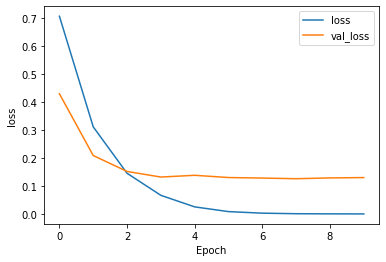

In [19]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')

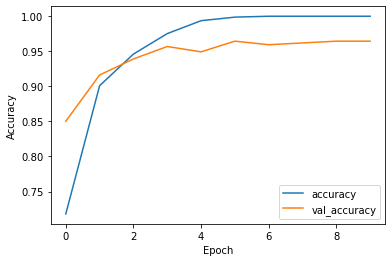

In [20]:
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [21]:
model.evaluate(x_valid, y_valid)

394/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.13013014457317298, 0.964467]

### 6. Test set

Analysis of hyperparameters:
- 10 epoch, batch_size=16, learning_rate=0.1 - [1.097268682042556, 0.37055838]
 
- 10 epoch, batch_size=32, learning_rate=0.1 - [1.1198053821896135, 0.3401015]

- 10 epoch, batch_size=64, learning_rate=0.1 - [1.094128987712505, 0.37055838]

- 10 epoch, batch_size=64, learning_rate=0.001 - [0.1878916552375416, 0.9407783]

- 10 epoch, batch_size=64, learning_rate=0.01 - [1.0990896372222254, 0.2893401]

- 10 epoch, batch_size=64, learning_rate=1.0 - [1.0991522888645102, 0.3401015]

- 10 epoch, batch_size=32, learning_rate=0.001 - [0.17450435519141227, 0.964467]

In [22]:
model.evaluate(x_test, y_test)

219/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.167605945508774, 0.9726027]

In [23]:
predictions = model.predict_classes(x_test)

(array([0, 1, 2], dtype=int64), array([77, 63, 79], dtype=int64))


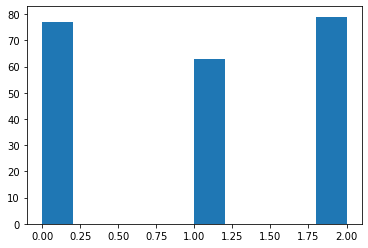

In [24]:
plt.hist(predictions)
print(np.unique(predictions, return_counts=True))

In [25]:
from sklearn.metrics import confusion_matrix, classification_report

In [26]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        82
           1       0.95      1.00      0.98        60
           2       0.96      0.99      0.97        77

    accuracy                           0.97       219
   macro avg       0.97      0.98      0.97       219
weighted avg       0.97      0.97      0.97       219



In [27]:
def print_imgs_with_predictions(x_set, y_set, preds, names):
    fig, ax = plt.subplots(4, 4, figsize=(8, 8), sharex='col', sharey='row')
    for x in range(4):
        for y in range(4):
            idx = random.randint(0, x_set.shape[0]-1)
            ax[x,y].imshow(x_set[idx], cmap='gray')
            ax[x,y].set_title('y:{}, pr:{}'.format(names[int(y_set[idx])], names[int(preds[idx])]))

In [28]:
wrong_indexes = [i for i, prediction in enumerate(predictions) if prediction != y_test[i]]
print('Number of wrong predictions: {}'.format(len(wrong_indexes)))
print('Number of samples in x_test: {}'.format(len(x_test)))

Number of wrong predictions: 6
Number of samples in x_test: 219


#### Predictions:

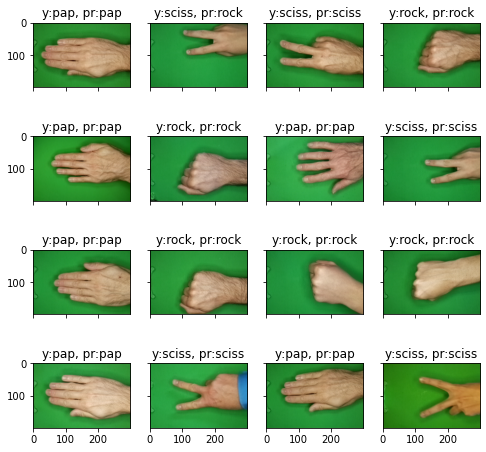

In [29]:
print_imgs_with_predictions(x_test, y_test, predictions, labels_dict)

#### Wrong predictions:

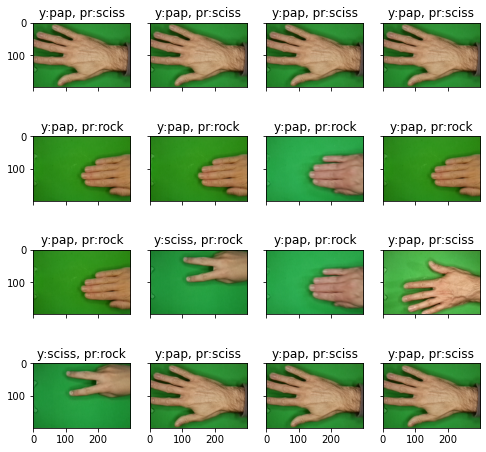

In [30]:
print_imgs_with_predictions(x_test[wrong_indexes], y_test[wrong_indexes], predictions[wrong_indexes], labels_dict)